In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from itertools import product
from scipy.stats import norm
from utils import kl_eigenfunctions, generate_quantization_points, reconstruct_quantized_trajectories,generate_brownian_motion,plot_brownian_trajectories,plot_brownian_bridge_samples,generate_brownian_bridge_samples

# Optimal quantization of the brownian motion 

Fonction qui génère des trajectoires de mouvement brownien.

Le code est capable de générer des trajectoires de mouvement brownien avec un point de départ fixe ou aléatoire. 

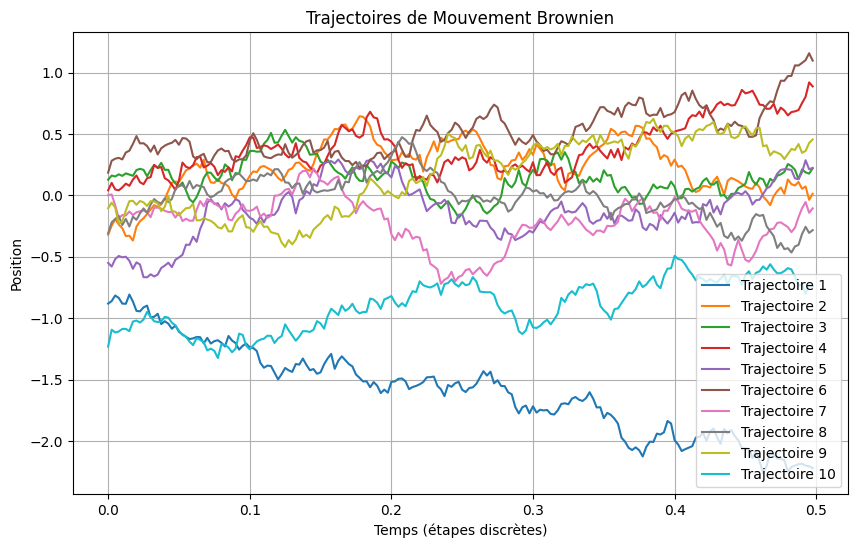

In [2]:
# Exemple d'utilisation
batch_size = 10
nb_step_simulation = 200
nb_timesteps_discretisation = 400
fixed_start_point = None #(0.2, 20)

trajectories = generate_brownian_motion(batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point)
plot_brownian_trajectories(trajectories, nb_step_simulation,nb_timesteps_discretisation)


## tMCL as a conditional k-means 

Implémentation de tMCL. 

In [3]:
import torch
import torch.nn as nn

class tMCL(nn.Module):
    def __init__(
        self, 
        cond_dim,       # dimension d'entrée (== 1, le point initial)
        nb_step_simulation,  # longueur des trajectoires générées
        n_hypotheses, 
        device,  
        loss_type = "relaxted_wta" 
    ):
        super().__init__()
       
        self.loss_type = loss_type
        self.nb_step_simulation = nb_step_simulation
        self.n_hypotheses = n_hypotheses

        self.backbone = nn.Sequential(
                nn.Linear(cond_dim, 50),
                nn.ReLU(),
                nn.Linear(50, 50)).to(device) #the backbone 
        
        self.prediction_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(50, nb_step_simulation)
            ).to(device)
            for _ in range(n_hypotheses)
        ])
       
       
    def forward(self, distr_args):
       
        # (A) Passer dans la backbone => [B, hidden_dim]
        features = self.backbone(distr_args)
        pred_list = []
        for head in self.prediction_heads:
            out = head(features)  # => [B, nb_step_simulation]
            pred_list.append(out)
        prediction_list = torch.stack(pred_list, dim=1)  # => [B, K, nb_step_simulation]
        return prediction_list




    def log_prob(self, target, distr_args):
        target = target.squeeze(-1)  # [B, nb_step_simulation]
        prediction_list = self.forward(distr_args)  # [B, K, nb_step_simulation]
        pairwise_mse = torch.sum((prediction_list - target.unsqueeze(1))**2, dim=-1)  # [B, K]

        if self.loss_type == "relaxted_wta":
            epsilon = 0.05
            n_hypotheses = pairwise_mse.shape[1]
            winner, _ = pairwise_mse.min(dim=1)
            mcl_loss = (1 - epsilon * n_hypotheses / (n_hypotheses - 1)) * winner + \
                       (epsilon / (n_hypotheses - 1)) * pairwise_mse.sum(dim=1)
            mcl_loss_mean = mcl_loss.mean()
            
        else:
            
        
            mcl_loss, _ = pairwise_mse.min(dim=1)
        
            mcl_loss_mean = mcl_loss.mean()

       
        return mcl_loss_mean


In [8]:

def train_tMCL(
    model, 
    num_epochs, 
    batch_size, 
    nb_step_simulation, 
    nb_timesteps_discretisation, 
    device, 
    learning_rate=0.001, 
    fixed_start_point=None
):
    """
    Entraîne le réseau de neurones tMCL avec des trajectoires browniennes.

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation sur [0, 1]
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :param fixed_start_point: Point de départ fixe pour les trajectoires (ou None pour aléatoire)
    :return: Modèle entraîné
    """
    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de trajectoires browniennes
        trajectories = generate_brownian_motion(
            batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point
        ).to(device)

        # Les points de départ : distr_args (extraire x0 des trajectoires)
        distr_args = trajectories[:, 0, :]#.squeeze(-1)  # [batch_size, 1]

        # Cibles : target_list (les trajectoires complètes)
        target_list = trajectories[:, :, :]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, distr_args)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


batch_size = 10000 #2000 was good
nb_step_simulation = 100
nb_timesteps_discretisation = 300
fixed_start_point =None # (0.2, 0)  # Exemple : (0.2, 20) ou None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir les hyperparamètres du modèle
model = tMCL(
    cond_dim=1, 
    nb_step_simulation=nb_step_simulation,
    n_hypotheses=10,
    device=device,
    loss_type = "relaxted_wta" #relaxted_wta
)

# Lancer l'entraînement
trained_model = train_tMCL(
    model=model,
    num_epochs=500,
    batch_size=batch_size,
    nb_step_simulation=nb_step_simulation,
    nb_timesteps_discretisation=nb_timesteps_discretisation,
    device=device,
    learning_rate=0.001,
    fixed_start_point=fixed_start_point
)


Epoch [10/500], Loss: 36.5575
Epoch [20/500], Loss: 21.8218
Epoch [30/500], Loss: 12.6873
Epoch [40/500], Loss: 8.8596
Epoch [50/500], Loss: 7.2740
Epoch [60/500], Loss: 6.4567
Epoch [70/500], Loss: 5.8692
Epoch [80/500], Loss: 5.4612
Epoch [90/500], Loss: 5.2541
Epoch [100/500], Loss: 5.0308
Epoch [110/500], Loss: 4.9100
Epoch [120/500], Loss: 4.8533
Epoch [130/500], Loss: 4.8006
Epoch [140/500], Loss: 4.7425
Epoch [150/500], Loss: 4.7143
Epoch [160/500], Loss: 4.7301
Epoch [170/500], Loss: 4.6987
Epoch [180/500], Loss: 4.7000
Epoch [190/500], Loss: 4.6389
Epoch [200/500], Loss: 4.6935
Epoch [210/500], Loss: 4.6330
Epoch [220/500], Loss: 4.6709
Epoch [230/500], Loss: 4.6646
Epoch [240/500], Loss: 4.6814
Epoch [250/500], Loss: 4.6633
Epoch [260/500], Loss: 4.6564
Epoch [270/500], Loss: 4.5700
Epoch [280/500], Loss: 4.6028
Epoch [290/500], Loss: 4.5932
Epoch [300/500], Loss: 4.6001
Epoch [310/500], Loss: 4.6362
Epoch [320/500], Loss: 4.6472
Epoch [330/500], Loss: 4.5878
Epoch [340/500],

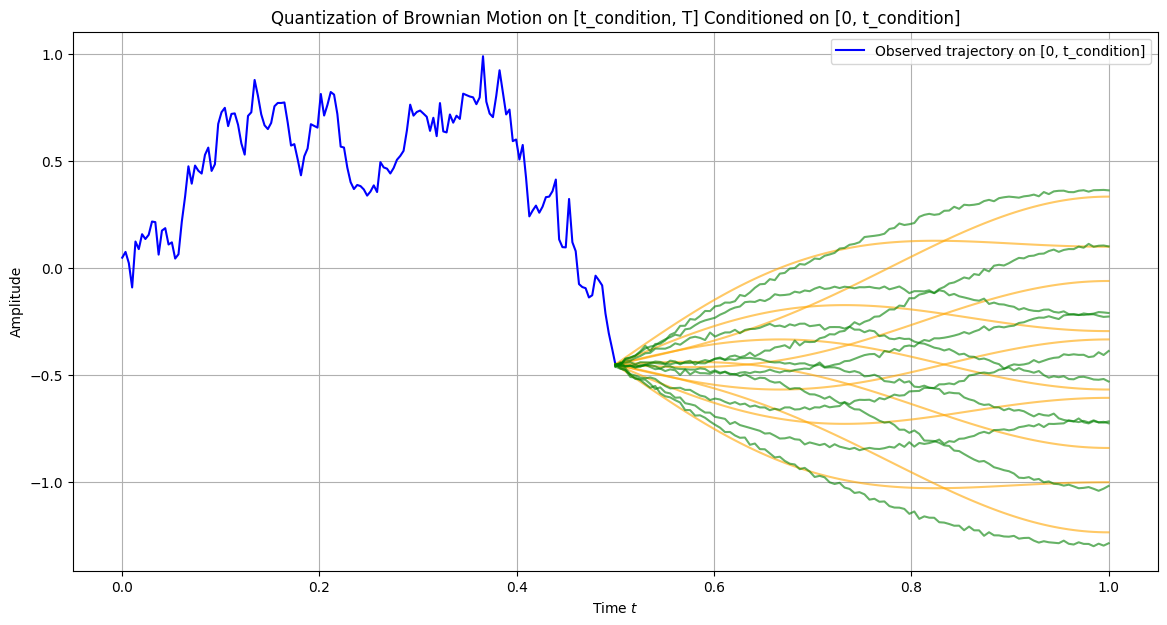

In [23]:
T = 1.0             # Intervalle de temps [0, T]
t_condition = 0.5  # Point où la trajectoire est connue
prediction_length = nb_step_simulation/ nb_timesteps_discretisation  #correspond to the prediciton length
num_steps = nb_timesteps_discretisation     # Nombre de points dans l'intervalle total
m = 2               # Nombre de dimensions utilisées (troncature)
N_levels = [5, 2]   # Niveaux de quantification pour chaque dimension

# Discrétisation de l'intervalle de temps
t_full = np.linspace(0, T, num_steps)
t_prediction = np.linspace(0, prediction_length, int(prediction_length * num_steps / T))
t_adjusted = np.linspace(t_condition, T, len(t_prediction))

# Calculer les fonctions propres et valeurs propres pour le mouvement brownien
eigenfunctions, eigenvalues = kl_eigenfunctions(t_prediction, prediction_length, m)

# Simuler une trajectoire Brownienne sur [0, t_condition]
#np.random.seed(42)
t_observed = np.linspace(0, t_condition, int(t_condition * num_steps / T))
trajectory_0_t = np.cumsum(np.sqrt(1 / len(t_observed)) * np.random.randn(len(t_observed)))

# Dernière valeur observée pour conditionner la quantification
B_t = trajectory_0_t[-1]

# Reconstruire les trajectoires quantifiées pour [0, prediction_length]
trajectories_quantized = reconstruct_quantized_trajectories(N_levels, eigenfunctions, eigenvalues) #nb hyp*timesteps
#here : adding the neural prediction and after good for plotting. 
predictions = trained_model.forward(torch.tensor([[float(B_t)]])) 
predictions_neural = predictions[0].detach().numpy()

# Ajouter B_t pour repositionner les trajectoires sur [t_condition, T]
trajectories_conditioned = trajectories_quantized + B_t

# Visualisation
plt.figure(figsize=(14, 7))

# Trajectoire observée sur [0, t_condition]
plt.plot(t_observed, trajectory_0_t, label="Observed trajectory on [0, t_condition]", color='blue')

# Trajectoires quantifiées sur [t_condition, T]
for trajectory in trajectories_conditioned:
    plt.plot(t_adjusted, trajectory, alpha=0.6, color='orange')

i=0
for trajectory in predictions_neural:
    i+=1
    # if i == 2:
    #     continue 
    plt.plot(t_adjusted, trajectory, alpha=0.6, color='green')
    

plt.title("Quantization of Brownian Motion on [t_condition, T] Conditioned on [0, t_condition]")
plt.xlabel("Time $t$")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [14]:
def plot_predictions(predictions, x0, nb_step_simulation):
    """
    Trace les trajectoires prédites par le modèle à partir des points initiaux x0.
    
    :param predictions: Tenseur de dimension [batch_size, K, nb_step_simulation] (prédictions du modèle)
    :param x0: Points initiaux x0, tensor [batch_size, 1]
    :param nb_step_simulation: Nombre d'étapes de simulation
    """
    batch_size, num_hypotheses, _ = predictions.shape
    
    # Configuration des axes
    time = torch.linspace(0, 1, nb_step_simulation).cpu().numpy()  # Discrétisation sur [0, 1]

    plt.figure(figsize=(12, 6))
    
    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        
        # Tracer toutes les hypothèses pour un exemple
        for k in range(num_hypotheses):
            plt.plot(time, predictions[i, k].detach().cpu().numpy(), label=f'Hypothesis {k + 1}')
        
        plt.title(f'Trajectories for x0={x0[i].item():.2f}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation
# Supposons que predictions et scores soient les sorties du modèle
# predictions = trained_model.forward(torch.tensor([[ -1.4]]))  # Utiliser x0 comme entrée
# plot_predictions(predictions, torch.tensor([[ -1.4]]), nb_step_simulation)


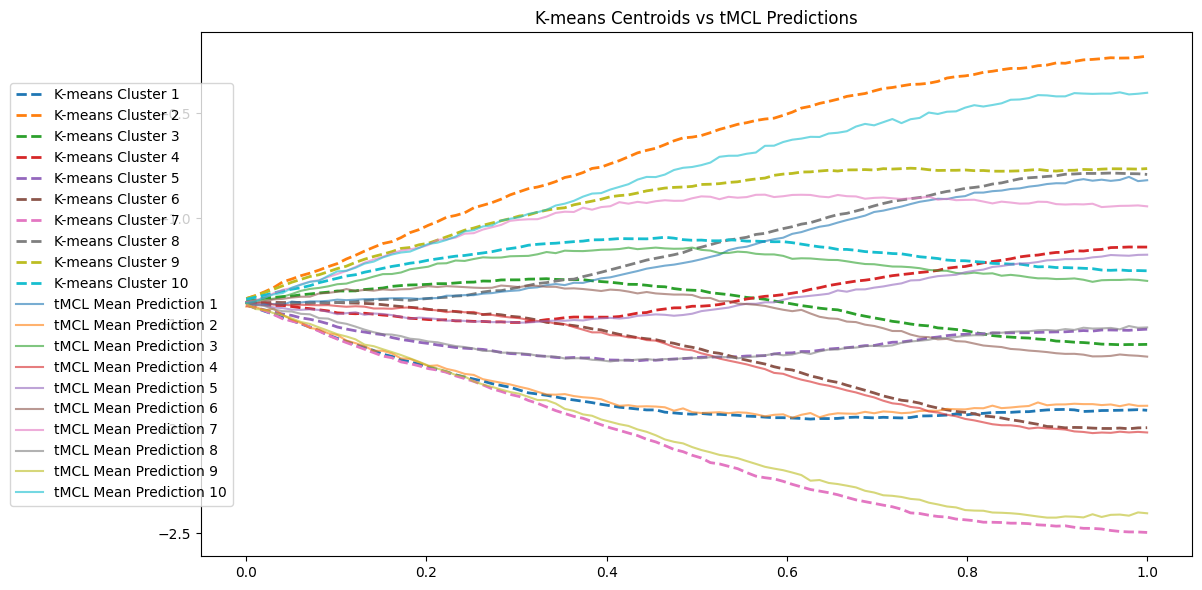

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_30387/3670403464.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


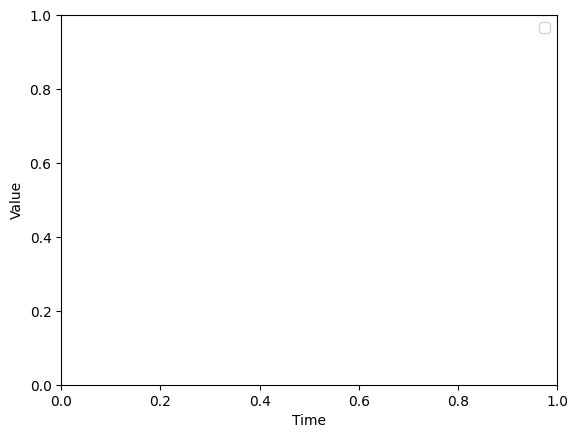

In [82]:
def plot_kmeans_centers_vs_tMCL(kmeans_centroids, tMCL_predictions, nb_step_simulation):
    """
    Trace les centres de clusters K-means et les trajectoires moyennes prédites par tMCL.
    
    :param kmeans_centroids: Centroides des clusters K-means [n_clusters, nb_step_simulation]
    :param tMCL_predictions: Trajectoires prédites par tMCL [batch_size, K, nb_step_simulation]
    :param nb_step_simulation: Nombre d'étapes de simulation
    """
    n_clusters = kmeans_centroids.shape[0]
    time = torch.linspace(0, 1, nb_step_simulation).cpu().numpy()

    # Moyenne des prédictions de tMCL sur les hypothèses
    tMCL_mean_predictions = tMCL_predictions.detach().cpu().numpy()  # [batch_size, nb_step_simulation]

    plt.figure(figsize=(12, 6))

    # Tracer les centroides de K-means
    for i, centroid in enumerate(kmeans_centroids):
        plt.plot(time, centroid, label=f'K-means Cluster {i + 1}', linestyle='--', linewidth=2)

    # Tracer les prédictions moyennes de tMCL
    for i in range(tMCL_mean_predictions.shape[0]):
        #if i ==6:
            # continue
        plt.plot(time, tMCL_mean_predictions[i], label=f'tMCL Mean Prediction {i + 1}', alpha=0.6)

    plt.title('K-means Centroids vs tMCL Predictions')
    # Positionner la légende à gauche
    plt.legend(loc='center left', bbox_to_anchor=(-0.2, 0.5), borderaxespad=0.5)
    
    plt.tight_layout()
    plt.show()
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Exemple d'utilisation
batch_size = 5000
nb_step_simulation = 100
nb_timesteps_discretisation = 300

nb_hypotheses = 10  # Doit correspondre au modèle
fixed_start_point = (0.2, -1.4)

# Générer les trajectoires browniennes
trajectories = generate_brownian_motion(
    batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point=fixed_start_point
).to(device)

x0 = trajectories[:, 0, :].squeeze(-1)  # Points initiaux [batch_size]

# Appliquer K-means sur les trajectoires
trajectories_flat = trajectories[:, :, 0].cpu().numpy()  # [batch_size, nb_step_simulation]
kmeans = KMeans(n_clusters=nb_hypotheses, random_state=42)
kmeans_labels = kmeans.fit_predict(trajectories_flat)

# Obtenir les centroides de K-means
kmeans_centroids = kmeans.cluster_centers_  # [n_clusters, nb_step_simulation]

# Obtenir les prédictions de tMCL
tMCL_predictions  = trained_model.forward(torch.tensor([[ -1.4]]))[0]  # [batch_size, K, nb_step_simulation]

# Tracer les résultats
plot_kmeans_centers_vs_tMCL(kmeans_centroids, tMCL_predictions, nb_step_simulation)


# Optimal quantization of the brownian bridge


lemme 10 https://almostsuremath.com/2021/03/29/brownian-bridges/ autorise de prendre un point x0 dans le brownian bridge. et de quantizer à partir de ce point. 

We can define a brownian bridge as a Brownian motion conditioned on hitting zero at T.

On genere des portions de trajectoire du brownian bridge, et on va quantizer à partir de ça sur (0,1).

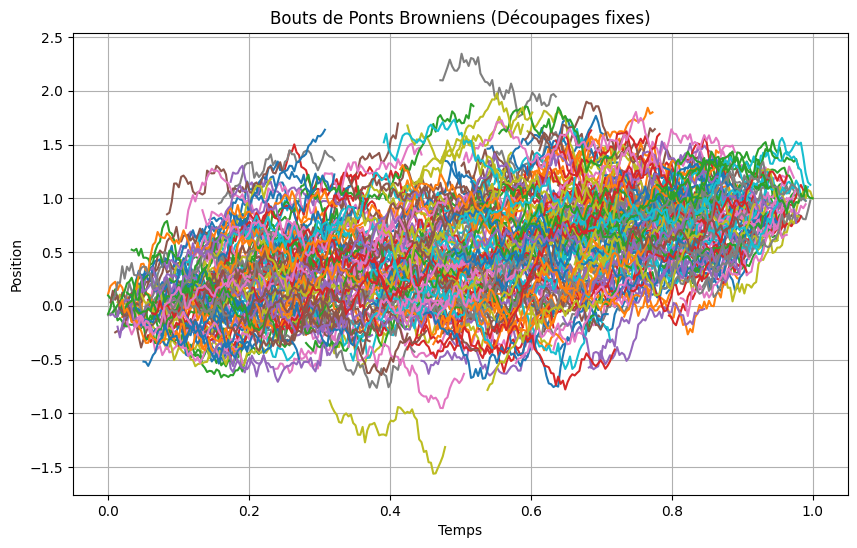

In [117]:
# Paramètres
batch_size = 500
nb_discretization_points = 300  # Résolution totale sur [0, 1]
interval_length = 50  # Nombre de points dans chaque sous-trajet
a, b = 0, 1  # Valeurs initiale et finale du pont brownien

# Génération des échantillons
samples, time_intervals = generate_brownian_bridge_samples(
    batch_size=batch_size,
    nb_discretization_points=nb_discretization_points,
    interval_length=interval_length,
    a=a,
    b=b
)

# Affichage des sous-trajets
plot_brownian_bridge_samples(samples, time_intervals)



In [174]:
def train_tMCL_for_bridge(
    model, 
    num_epochs, 
    batch_size, 
    nb_discretization_points, 
    interval_length,
    device, 
    learning_rate=0.001
):
    """
    Entraîne le réseau de neurones tMCL avec des bouts de trajectoires browniennes.

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées (bouts)
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation sur [0, 1]
    :param interval_length: Longueur de chaque bout en nombre de points
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :return: Modèle entraîné
    """
    import torch.optim as optim

    # Définir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de bouts de trajectoires browniennes
        trajectories, time_intervals = generate_brownian_bridge_samples(
            batch_size=batch_size,
            nb_discretization_points=nb_discretization_points,
            interval_length=interval_length,
            a=0,
            b=1
        )
        trajectories = trajectories.to(device)
        time_intervals = time_intervals.to(device)

        # Extraire t0 pour l'état caché
        t0 = time_intervals[:, 0].unsqueeze(-1)  # [batch_size, 1]

        # Ajouter t0 en tant qu'entrée cachée
        distr_args = torch.cat([trajectories[:, 0, :], t0], dim=-1)  # [batch_size, cond_dim]

        # Les cibles : target_list (les trajectoires complètes)
        target_list = trajectories[:, :, :]  # [batch_size, nb_step_simulation, 1]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, distr_args)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


In [182]:
# Définir les paramètres
batch_size = 5000
nb_discretization_points = 300

interval_length = 150  # La longueur des bouts correspond à la taille des simulations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = tMCL(
    cond_dim=2,  # 1 pour la valeur de départ + 1 pour t0
    nb_step_simulation=interval_length,
    n_hypotheses=10,
    device=device,
    loss_type="relaxed_wta"  # Utilisation de la perte WTA
)

# Lancer l'entraînement
trained_model = train_tMCL_for_bridge(
    model=model,
    num_epochs=2500,
    batch_size=batch_size,
    nb_discretization_points=nb_discretization_points,
    interval_length=interval_length,
    device=device,
    learning_rate=0.001
)


Epoch [10/2500], Loss: 54.8838
Epoch [20/2500], Loss: 30.2679
Epoch [30/2500], Loss: 16.4480
Epoch [40/2500], Loss: 10.4898
Epoch [50/2500], Loss: 8.6580
Epoch [60/2500], Loss: 7.8905
Epoch [70/2500], Loss: 7.3573
Epoch [80/2500], Loss: 7.0619
Epoch [90/2500], Loss: 6.7598
Epoch [100/2500], Loss: 6.6442
Epoch [110/2500], Loss: 6.5057
Epoch [120/2500], Loss: 6.4468
Epoch [130/2500], Loss: 6.4687
Epoch [140/2500], Loss: 6.4638
Epoch [150/2500], Loss: 6.3485
Epoch [160/2500], Loss: 6.3249
Epoch [170/2500], Loss: 6.4582
Epoch [180/2500], Loss: 6.3212
Epoch [190/2500], Loss: 6.2629
Epoch [200/2500], Loss: 6.2807
Epoch [210/2500], Loss: 6.3298
Epoch [220/2500], Loss: 6.2562
Epoch [230/2500], Loss: 6.1600
Epoch [240/2500], Loss: 6.1161
Epoch [250/2500], Loss: 6.1390
Epoch [260/2500], Loss: 6.1595
Epoch [270/2500], Loss: 6.1119
Epoch [280/2500], Loss: 5.9847
Epoch [290/2500], Loss: 5.9866
Epoch [300/2500], Loss: 5.9745
Epoch [310/2500], Loss: 5.9445
Epoch [320/2500], Loss: 5.9079
Epoch [330/25

In [183]:
trained_model.forward(torch.tensor([[ 1,0.6]]))[0].shape

torch.Size([10, 150])

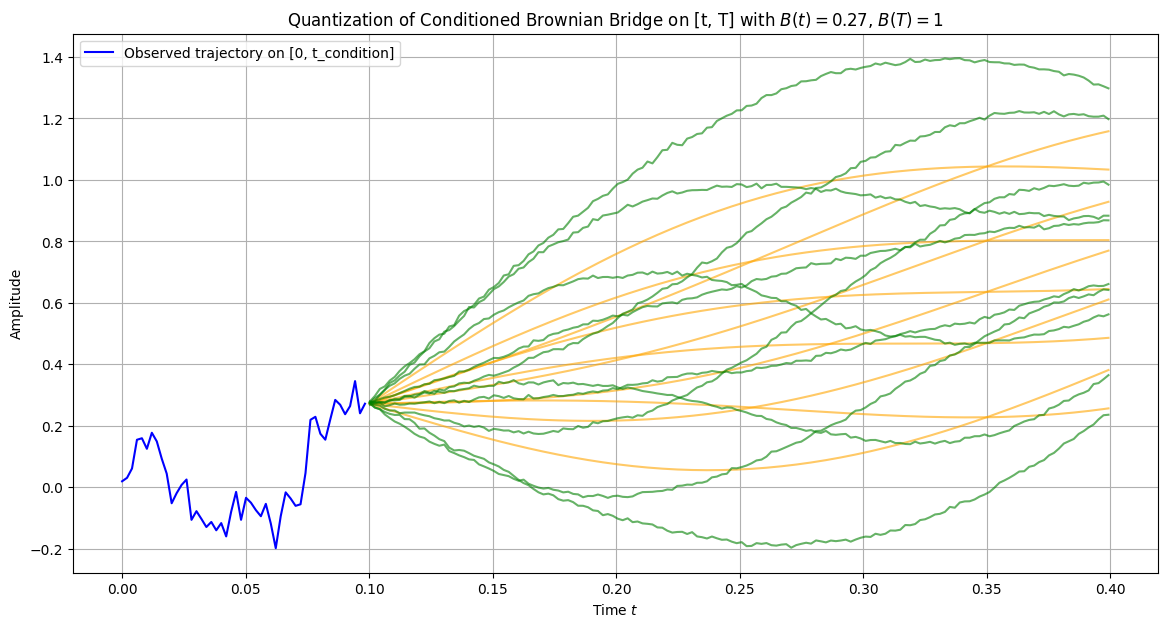

In [201]:

# Définir les fonctions propres de Karhunen-Loève pour le pont brownien
def kl_eigenfunctions(t, T, m):
    """
    Calcule les m premières fonctions propres et valeurs propres pour le pont brownien.
    :param t: Points de discrétisation sur l'intervalle [0, T]
    :param T: Longueur totale de l'intervalle [0, T]
    :param m: Nombre de fonctions propres et valeurs propres à calculer
    :return: Liste des fonctions propres et des valeurs propres
    """
    eigenfunctions = []
    eigenvalues = []
    for n in range(1, m + 1):
        # Fonction propre e_n(t)
        eigenfunc = np.sqrt(2 / T) * np.sin(np.pi * n * t / T)
        # Valeur propre lambda_n
        eigenval = (T / (n * np.pi))**2
        eigenfunctions.append(eigenfunc)
        eigenvalues.append(eigenval)
    return np.array(eigenfunctions), np.array(eigenvalues)

# Générer les points de quantification optimaux pour une loi normale
def generate_quantization_points(N, dist_mean=0, dist_var=1):
    """
    Génère les points optimaux pour quantifier une loi normale centrée.
    """
    std_dev = np.sqrt(dist_var)
    return norm.ppf(np.linspace(1 / (2 * N), 1 - 1 / (2 * N), N)) * std_dev

# Reconstruire les trajectoires quantifiées pour un pont brownien conditionné
def reconstruct_quantized_trajectories_conditioned(N_levels, eigenfunctions, eigenvalues, t, x, b):
    """
    Reconstruit les trajectoires quantifiées pour un pont brownien conditionné qui commence en x à t et termine en b à T.
    :param N_levels: Liste des niveaux de quantification par dimension [N1, N2, ..., Nm]
    :param eigenfunctions: Liste des fonctions propres
    :param eigenvalues: Liste des valeurs propres
    :param t: Points de discrétisation sur l'intervalle [t, T]
    :param x: Valeur initiale du pont à t
    :param b: Valeur finale du pont à T
    """
    m = len(N_levels)
    quantization_grids = [generate_quantization_points(N, dist_var=1) for N in N_levels]
    multi_indices = list(product(*[range(len(grid)) for grid in quantization_grids]))
    
    # Interpolation linéaire pour conditions aux bords
    linear_interpolation = (1 - (t - t[0]) / (t[-1] - t[0])) * x + ((t - t[0]) / (t[-1] - t[0])) * b
    
    trajectories = []
    for index in multi_indices:
        # Calcul des trajectoires quantifiées
        trajectory = sum(
            np.sqrt(eigenvalues[n]) * quantization_grids[n][index[n]] * eigenfunctions[n]
            for n in range(m)
        )
        # Ajouter l'interpolation linéaire
        trajectories.append(trajectory + linear_interpolation)
    
    return np.array(trajectories)

# Paramètres

t_condition = 0.1  # Point de conditionnement
T = t_condition + interval_length/nb_discretization_points
num_steps = nb_discretization_points     # Nombre de points dans l'intervalle
m = 2               # Nombre de dimensions utilisées (troncature)
N_levels = [5, 2]   # Niveaux de quantification par dimension
a = 0             # Valeur initiale du pont brownien
b = 1          # Valeur finale du pont brownien

# Discrétisation de l'intervalle [0, T]
t_full = np.linspace(0, T, num_steps)

# Simulation d'une trajectoire de pont brownien sur [0, T]
#np.random.seed(42)
W = np.cumsum(np.sqrt(1 / len(t_full)) * np.random.randn(len(t_full)))  # Mouvement brownien
bridge_0_T = W - (t_full / T) * W[-1] + (1 - t_full / T) * a + t_full / T * b

# Tronquer la trajectoire à [0, t_condition]
t_observed = t_full[t_full <= t_condition]
bridge_0_t = bridge_0_T[:len(t_observed)]

# Dernière valeur observée pour conditionner la suite
B_t = bridge_0_t[-1]

# Calculer les fonctions propres et valeurs propres pour le pont sur [t_condition, T]
t_quantized = t_full[t_full >= t_condition]
eigenfunctions, eigenvalues = kl_eigenfunctions(t_quantized - t_condition, T - t_condition, m)

# Reconstruire les trajectoires quantifiées pour le pont brownien conditionné
trajectories_quantized = reconstruct_quantized_trajectories_conditioned(
    N_levels, eigenfunctions, eigenvalues, t_quantized, B_t, b
)


predictions_neural = trained_model.forward(torch.tensor([[ float(B_t),0.3]]))[0].detach().numpy()
# Visualisation
plt.figure(figsize=(14, 7))

# Trajectoire simulée sur [0, t_condition]
plt.plot(t_observed, bridge_0_t, label="Observed trajectory on [0, t_condition]", color='blue')

# Trajectoires quantifiées sur [t_condition, T]
for trajectory in trajectories_quantized:
    plt.plot(t_quantized[:len(predictions_neural[0])], trajectory[:len(predictions_neural[0])], alpha=0.6, color='orange')

i=0
for trajectory in predictions_neural:
    i+=1
    #if i == 2:
        #continue 
    plt.plot(t_quantized[:len(predictions_neural[0])], trajectory, alpha=0.6, color='green')

plt.title(f"Quantization of Conditioned Brownian Bridge on [t, T] with $B(t)={B_t:.2f}$, $B(T)={b}$")
plt.xlabel("Time $t$")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [202]:
import pickle

# Définir les données à sauvegarder
data_to_save = {
    "t_observed": t_observed,
    "bridge_0_t": bridge_0_t,
    "t_quantized": t_quantized,
    "trajectories_quantized": trajectories_quantized,
    "predictions_neural": predictions_neural,
    "B_t": B_t,
    "b": b
}

# Sauvegarder dans un fichier pickle
with open("bridge_data5.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

print("Data saved successfully to 'plot_data.pkl'")


Data saved successfully to 'plot_data.pkl'


# Autoregressif here 

Just need to add the AR here. 

## Conditionnal tMCL 

The only two useful information for the conditional tMCL in the case of a brownian motion is the initial point x0 and the step t at which we want to predict the trajectory. 

In [207]:
class condtMCL(nn.Module):
    def __init__(
        self,
        cond_dim,            # dimension d'entrée par time-step (nb_info_hidden_state)
        nb_step_simulation,  # longueur de la série temporelle
        n_hypotheses,        # nombre d'hypothèses (K)
        device,
        loss_type="relaxed_wta"
    ):
        super().__init__()

        self.loss_type = loss_type
        self.nb_step_simulation = nb_step_simulation
        self.n_hypotheses = n_hypotheses

        # Backbone (appliqué à chaque time-step)
        self.backbone = nn.Sequential(
            nn.Linear(cond_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10)
        ).to(device)

        # Têtes de prédiction (K hypothèses)
        self.prediction_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(10, 1)  # Prévoir une valeur par time-step
            ).to(device)
            for _ in range(n_hypotheses)
        ])

    def forward(self, distr_args):
        """
        Prédictions pour chaque time-step conditionnellement à distr_args.

        :param distr_args: [batch_size, time_series_length, cond_dim]
        :return: prediction_list [batch_size, K, time_series_length]
        """
        B, T, C = distr_args.shape

        # Appliquer le backbone à chaque time-step
        features = self.backbone(distr_args.reshape(B * T, C))  # [B*T, 10]
        features = features.view(B, T, -1)  # [B, T, 10]

        # Générer les prédictions pour chaque hypothèse
        pred_list = []
        for head in self.prediction_heads:
            out = head(features).squeeze(-1)  # [B, T, 1] -> [B, T]
            pred_list.append(out)

        # Empiler les prédictions pour obtenir [B, K, T]
        prediction_list = torch.stack(pred_list, dim=1)
        return prediction_list

    def log_prob(self, target, distr_args):
        """
        Calcul de la perte pour les prédictions conditionnelles.

        :param target: [batch_size, time_series_length]
        :param distr_args: [batch_size, time_series_length, cond_dim]
        :return: mcl_loss_mean
        """
        prediction_list = self.forward(distr_args)  # [B, K, T]
        pairwise_mse = torch.sum((prediction_list - target.unsqueeze(1).squeeze(-1)  ) ** 2, dim=-1)  # [B, K]

        if self.loss_type == "relaxed_wta":
            epsilon = 0.1
            n_hypotheses = pairwise_mse.shape[1]
            winner, _ = pairwise_mse.min(dim=1)
            mcl_loss = (1 - epsilon * n_hypotheses / (n_hypotheses - 1)) * winner + \
                       (epsilon / (n_hypotheses - 1)) * pairwise_mse.sum(dim=1)
            mcl_loss_mean = mcl_loss.mean()

        else:
            mcl_loss, _ = pairwise_mse.min(dim=1)
            mcl_loss_mean = mcl_loss.mean()

        return mcl_loss_mean


In [272]:
def train_tMCL(
    model, 
    num_epochs, 
    batch_size, 
    nb_step_simulation, 
    nb_timesteps_discretisation, 
    device, 
    learning_rate=0.001, 
    fixed_start_point=None
):
    """
    Entraîne le réseau de neurones tMCL avec des trajectoires browniennes.

    :param model: Instance du modèle tMCL
    :param num_epochs: Nombre d'époques d'entraînement
    :param batch_size: Taille du batch pour la génération de trajectoires
    :param nb_step_simulation: Longueur des trajectoires simulées
    :param nb_timesteps_discretisation: Nombre total de points de discrétisation sur [0, 1]
    :param device: Dispositif d'exécution (CPU ou GPU)
    :param learning_rate: Taux d'apprentissage
    :param fixed_start_point: Point de départ fixe pour les trajectoires (ou None pour aléatoire)
    :return: Modèle entraîné
    """
    # Définir l'optimiseur
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Basculer le modèle en mode entraînement
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        # Générer un batch de trajectoires browniennes
        trajectories = generate_brownian_motion(
            batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point
        ).to(device)

        # Générer un état caché aléatoire
        x0_values = trajectories[:, 0, 0]  # [batch_size]
        timesteps = torch.linspace(0, 1, nb_step_simulation).to(device)  # [T]
        timesteps = timesteps.unsqueeze(0).repeat(batch_size, 1)  # [B, T]
        x0_repeated = x0_values.unsqueeze(1).repeat(1, nb_step_simulation)  
        hidden_state = torch.stack([x0_repeated, timesteps], dim=-1)  # [B, T, 2]

        #hidden_state = torch.randn(batch_size, nb_step_simulation, 3).to(device)  # [batch_size, time_series_length, cond_dim]

        # Cibles : target_list (les trajectoires complètes)
        target_list = trajectories[:, :, :]  # [batch_size, nb_step_simulation, 1]

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Calculer les prédictions et la perte
        loss = model.log_prob(target_list, hidden_state)

        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids
        optimizer.step()

        # Afficher les progrès
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    return model


# Paramètres
batch_size = 1000
nb_step_simulation = 100
nb_timesteps_discretisation = 300
fixed_start_point = None  # Exemple : (0.2, 0) ou None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Définir les hyperparamètres du modèle
model = condtMCL(
    cond_dim=2,  # Dimension de l'état caché
    nb_step_simulation=nb_step_simulation,
    n_hypotheses=10,  # Nombre d'hypothèses
    device=device,
    loss_type="wta"
)

# Lancer l'entraînement
trained_model = train_tMCL(
    model=model,
    num_epochs=5000,
    batch_size=batch_size,
    nb_step_simulation=nb_step_simulation,
    nb_timesteps_discretisation=nb_timesteps_discretisation,
    device=device,
    learning_rate=0.001,
    fixed_start_point=fixed_start_point
)


Epoch [10/5000], Loss: 19.7672
Epoch [20/5000], Loss: 17.1650
Epoch [30/5000], Loss: 16.7340
Epoch [40/5000], Loss: 13.5079
Epoch [50/5000], Loss: 12.5090
Epoch [60/5000], Loss: 10.6097
Epoch [70/5000], Loss: 8.5982
Epoch [80/5000], Loss: 9.4779
Epoch [90/5000], Loss: 7.6995
Epoch [100/5000], Loss: 7.7888
Epoch [110/5000], Loss: 6.8710
Epoch [120/5000], Loss: 6.2926
Epoch [130/5000], Loss: 6.1568
Epoch [140/5000], Loss: 6.1633
Epoch [150/5000], Loss: 5.8714
Epoch [160/5000], Loss: 5.5438
Epoch [170/5000], Loss: 5.5281
Epoch [180/5000], Loss: 5.8359
Epoch [190/5000], Loss: 5.6912
Epoch [200/5000], Loss: 5.6750
Epoch [210/5000], Loss: 5.6130
Epoch [220/5000], Loss: 5.4417
Epoch [230/5000], Loss: 5.2629
Epoch [240/5000], Loss: 5.4800
Epoch [250/5000], Loss: 5.0073
Epoch [260/5000], Loss: 5.0669
Epoch [270/5000], Loss: 4.9729
Epoch [280/5000], Loss: 4.9160
Epoch [290/5000], Loss: 4.6082
Epoch [300/5000], Loss: 4.4860
Epoch [310/5000], Loss: 4.6752
Epoch [320/5000], Loss: 4.5124
Epoch [330/

KeyboardInterrupt: 

In [273]:
hidden_state = torch.randn(1, 3, 2).to(device)

timesteps = torch.linspace(0, 1, nb_step_simulation).to(device)  # [T]
timesteps = timesteps.unsqueeze(0)  # [1, T]

# Répéter x0_value pour chaque timestep
x0_repeated = torch.full_like(timesteps, 1.2)  # [1, T]

# Combiner x0 et timesteps pour former l'état caché
hidden_state = torch.stack([x0_repeated, timesteps], dim=-1)  # [1, T, 2]

In [274]:
predictions = model.forward(hidden_state)


In [275]:
predictions.shape

torch.Size([1, 10, 100])

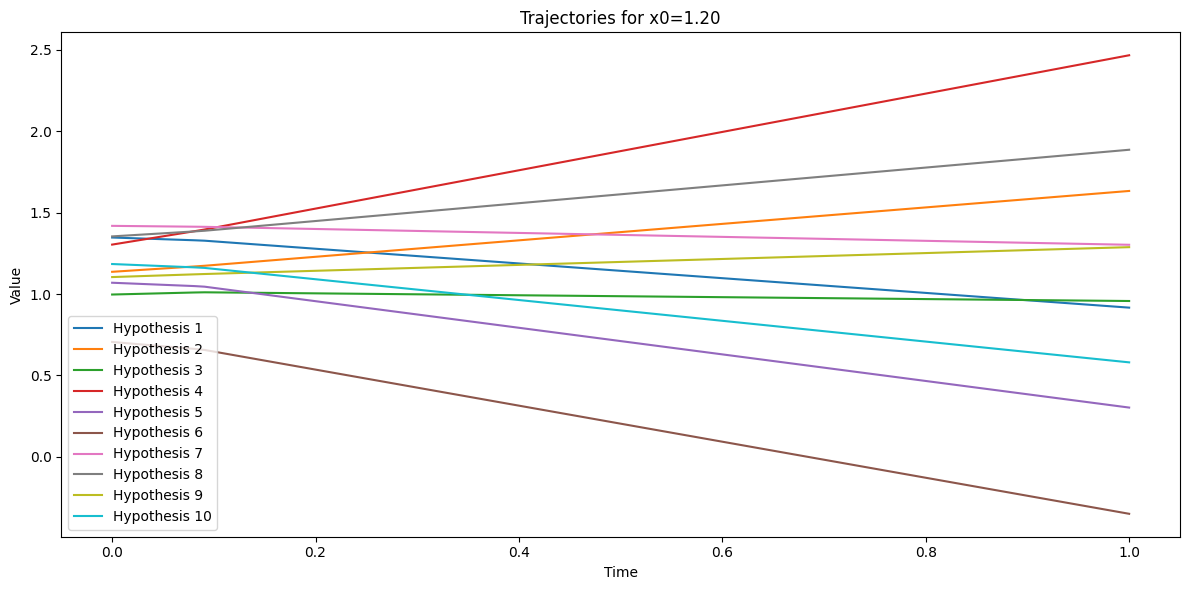

In [277]:
plot_predictions(predictions, torch.tensor([[ 1.2]]), 100)

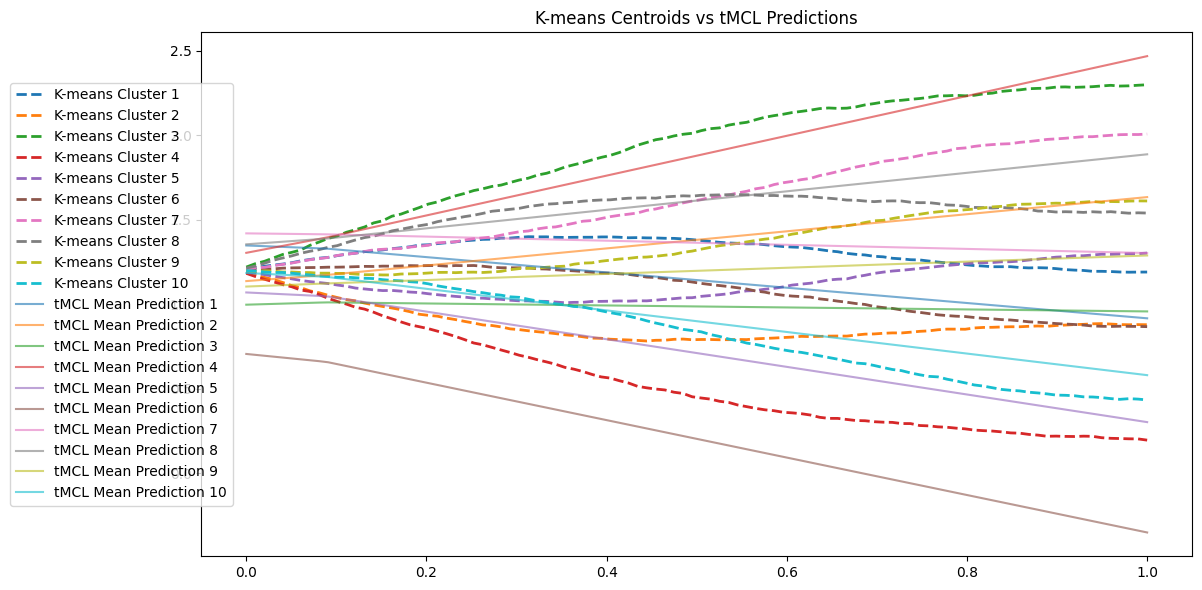

/var/folders/jb/8bmzmwqn3h14s2z9jr4gfg880000gn/T/ipykernel_21972/3670403464.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


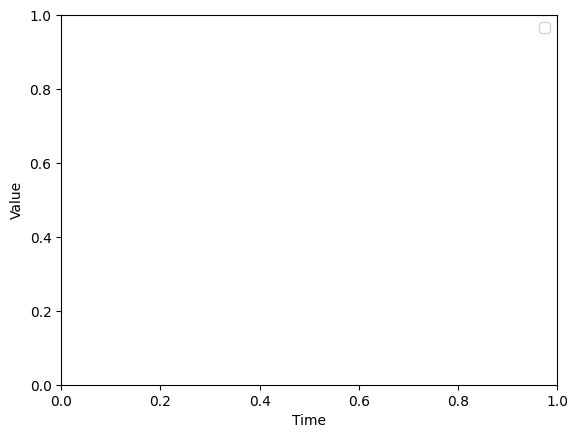

In [281]:
# Exemple d'utilisation
batch_size = 5000
nb_step_simulation = 100
nb_timesteps_discretisation = 300

nb_hypotheses = 10  # Doit correspondre au modèle
fixed_start_point = (0.2, 1.2)

# Générer les trajectoires browniennes
trajectories = generate_brownian_motion(
    batch_size, nb_step_simulation, nb_timesteps_discretisation, fixed_start_point=fixed_start_point
).to(device)

x0 = trajectories[:, 0, :].squeeze(-1)  # Points initiaux [batch_size]

# Appliquer K-means sur les trajectoires
trajectories_flat = trajectories[:, :, 0].cpu().numpy()  # [batch_size, nb_step_simulation]
kmeans = KMeans(n_clusters=nb_hypotheses, random_state=42)
kmeans_labels = kmeans.fit_predict(trajectories_flat)

# Obtenir les centroides de K-means
kmeans_centroids = kmeans.cluster_centers_  # [n_clusters, nb_step_simulation]

# Obtenir les prédictions de tMCL
#tMCL_predictions  = trained_model.forward(torch.tensor([[ -1.4]]))[0]  # [batch_size, K, nb_step_simulation]
tMCL_predictions = model.forward(hidden_state)[0]
# Tracer les résultats
plot_kmeans_centers_vs_tMCL(kmeans_centroids, tMCL_predictions, nb_step_simulation)